# Eval Diffusion Model
### Imports

In [1]:
try: 
    import librosa
except:
    !pip install librosa

#Set Dir 
import sys, os
sys.path.append(os.path.abspath('..'))
# Torch
import torch
from torch import nn, Tensor
from torch.utils.data import DataLoader
import torch.optim as optim
# Utils
import numpy as np
from numpy import ndarray
import logging

# Base Scripts
from Libraries.U_Net import *
from Libraries.Diffusion import *
from Libraries.Utils import *
from MainScripts.Conf import conf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.7/260.7 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 403.7/403.7 kB 37.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 70.8 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.6/64.6 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 53.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 252.5/252.5 kB 33.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 MB 42.3 MB/s eta 0:00:00:00:0100:01


### Conf

In [2]:
remote_kernel: bool = True

device = "cuda" if torch.cuda.is_available() else "cpu"
model_name: str = "diffusion_v18"
training_data_name: str = "training_full_low_res"
model_path: str = path_to_remote_path("{}/{}".format(conf["paths"].model_path, model_name + ".pth"), remote_kernel)
logging_level: int = LIGHT_DEBUG
logging.basicConfig(level=logging_level, format='%(asctime)s - %(levelname)s - %(message)s')
logger: logging.Logger = logging.getLogger(__name__)

### Functions

In [3]:
def bwd_pass(model: Diffusion, n_samples: int = 1, file_name: str = "test") -> None:
    x: ndarray = model.bwd_diffusion(n_samples=n_samples)
    print(x[0,0].shape)
    for i in range(x.shape[0]):
        logger.info(f"Sample {i}")
        visualize_spectogram(x[i, 0])
        audio = spectrogram_to_audio(unnormalize(x[i, 0]), conf["audio"].len_fft)
        save_audio_file(audio, path_to_remote_path("{}/{}".format(conf["paths"].result_path, f"{file_name}_{i:02d}_out.wav"), remote_kernel))
    logger.light_debug("Saved passed through samples to {}".format(conf["paths"].result_path))



def print_eval_metrics(data: ndarray) -> None:
    if data.ndim == 2:
        data = np.expand_dims(data, axis = 0)
    for i, sample in enumerate(data):
        sc_score = spectral_convergence(sample, len_fft=conf["audio"].len_fft, hop_length=conf["audio"].len_hop, sample_rate=conf["audio"].sample_rate)
        sdr_score = sdr(sample, sample_rate=conf["audio"].sample_rate, cutoff=4000)
        print(f"Sample {(i + 1):02d} Spectral Convergence: {sc_score:.4f} SDR score: {sdr_score:.2f} dB")


### Data Loading & Model Creation

In [5]:
file = load_training_data(path_to_remote_path("{}/{}".format(conf["paths"].data_path, training_data_name + ".npy"), remote_kernel))[:100,...]
logger.info(f"Data loaded with shape: {file.shape}")

u_net = Conv_U_NET(in_channels=1,
                    time_embed_dim=conf["model"].time_embed_dim, 
                    n_starting_filters=conf["model"].n_starting_filters, 
                    n_downsamples=conf["model"].n_downsamples, 
                    activation=nn.GELU(), 
                    device=device,
                    conditional_norm=True
                ).to(device)

if os.path.exists(model_path):
    u_net.load_state_dict(torch.load(model_path, map_location=device)["model"])
    logger.info(f"Model {model_name} loaded with {count_parameters(u_net)} Parameters")
else:
    raise AssertionError(f"No Model with {model_name} found!")

diffusion = Diffusion(model=u_net, 
                        noise_steps=conf["model"].diffusion_timesteps, 
                        noise_schedule="cosine", 
                        input_dim=[conf["model"].batch_size, 1, file.shape[-2], file.shape[-1]],
                        device=device
                    )


2025-03-25 09:28:40,996 - LIGHT_DEBUG - Ndarray loaded from Data/training_full_low_res.npy of shape: (7087, 224, 416)
2025-03-25 09:28:41,008 - INFO - Data loaded with shape: (100, 224, 416)
2025-03-25 09:28:41,748 - INFO - Model diffusion_v18 loaded with 18989281 Parameters


### Evaluate

2025-03-25 09:28:46,480 - INFO - Started sampling 8 samples


2025-03-25 09:29:06,000 - LIGHT_DEBUG - Sampling timestep 100/1000 X min/max: -4.26996, 5.65880 noise min/max: -4.60233, 5.82459 std/mean: 1.02366, 0.07180 

2025-03-25 09:29:06,572 - LIGHT_DEBUG - Normalized to range: [-1,1]


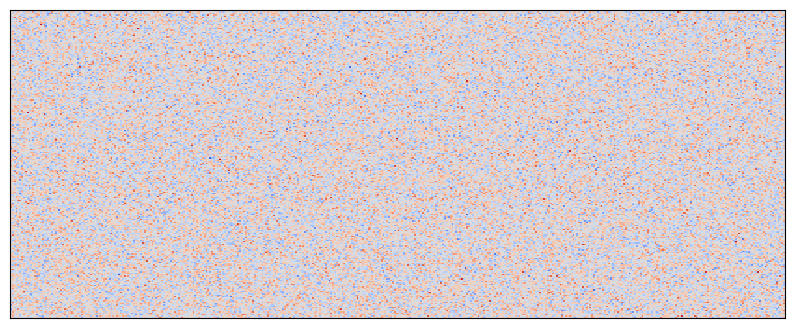

2025-03-25 09:29:26,000 - LIGHT_DEBUG - Sampling timestep 200/1000 X min/max: -4.22638, 4.92292 noise min/max: -4.74555, 4.93020 std/mean: 1.04930, 0.10090 

2025-03-25 09:29:26,515 - LIGHT_DEBUG - Normalized to range: [-1,1]


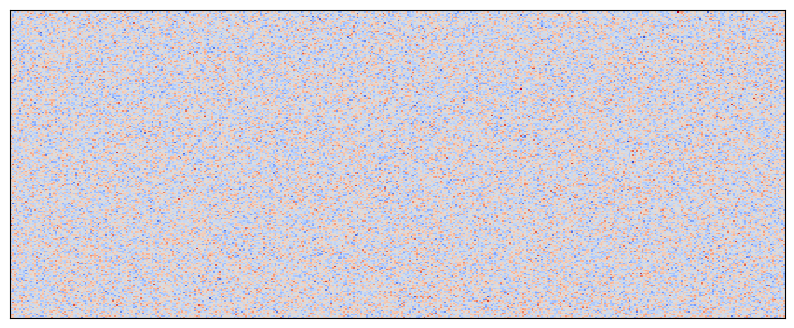

2025-03-25 09:29:46,000 - LIGHT_DEBUG - Sampling timestep 300/1000 X min/max: -4.11343, 5.10653 noise min/max: -4.72948, 5.25679 std/mean: 1.09354, 0.12037 

2025-03-25 09:29:46,425 - LIGHT_DEBUG - Normalized to range: [-1,1]


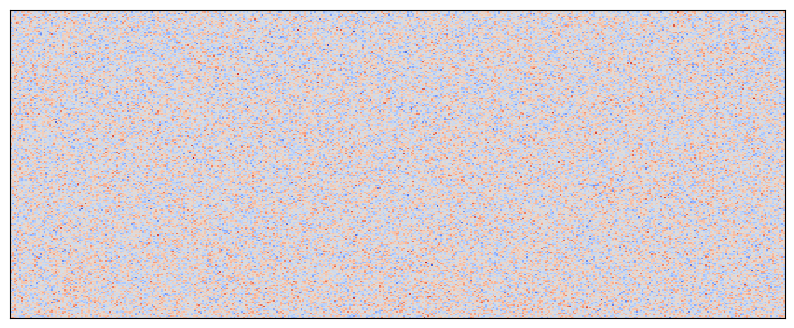

2025-03-25 09:30:06,000 - LIGHT_DEBUG - Sampling timestep 400/1000 X min/max: -4.58340, 5.15430 noise min/max: -5.58212, 5.76816 std/mean: 1.17217, 0.18055 

2025-03-25 09:30:06,596 - LIGHT_DEBUG - Normalized to range: [-1,1]


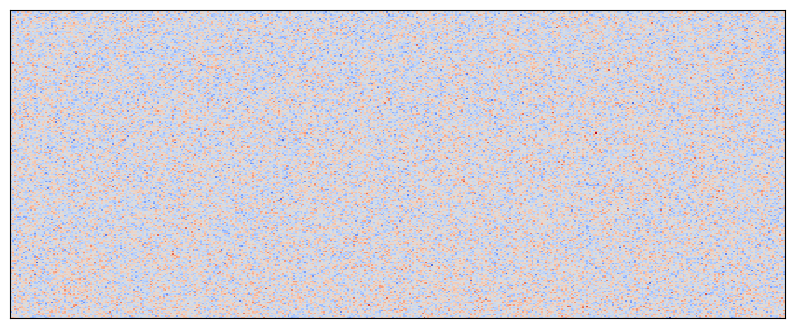

2025-03-25 09:30:26,000 - LIGHT_DEBUG - Sampling timestep 500/1000 X min/max: -4.54999, 5.17897 noise min/max: -6.01985, 6.11562 std/mean: 1.27459, 0.20371 

2025-03-25 09:30:26,560 - LIGHT_DEBUG - Normalized to range: [-1,1]


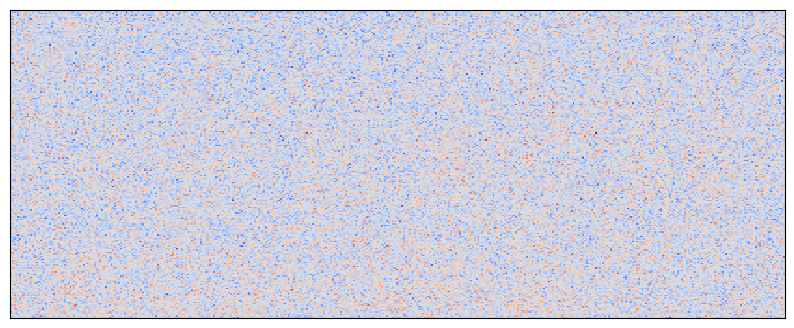

2025-03-25 09:30:46,000 - LIGHT_DEBUG - Sampling timestep 600/1000 X min/max: -4.68888, 5.14402 noise min/max: -6.39383, 6.77273 std/mean: 1.37835, 0.28188 

2025-03-25 09:30:46,599 - LIGHT_DEBUG - Normalized to range: [-1,1]


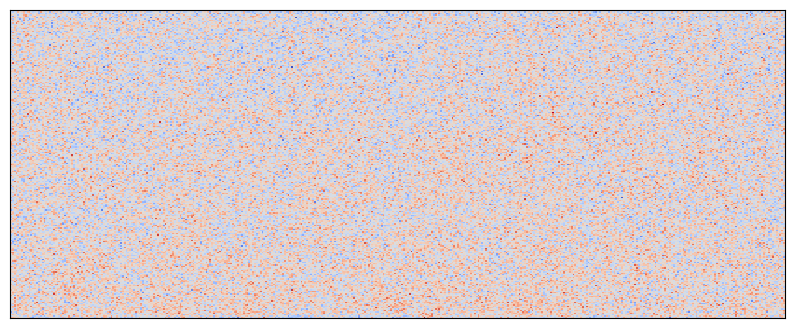

2025-03-25 09:31:06,000 - LIGHT_DEBUG - Sampling timestep 700/1000 X min/max: -4.68705, 5.29273 noise min/max: -6.71769, 7.36782 std/mean: 1.48850, 0.43426 

2025-03-25 09:31:06,643 - LIGHT_DEBUG - Normalized to range: [-1,1]


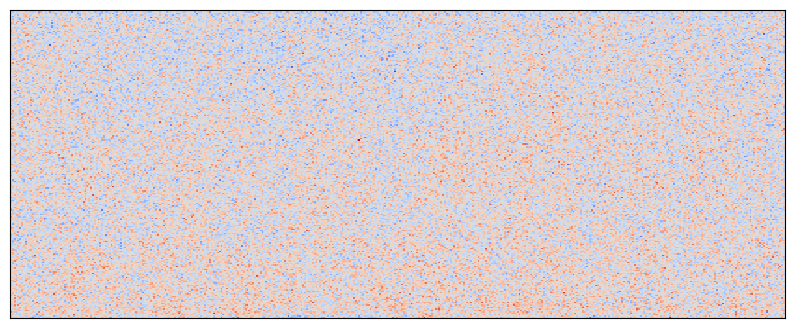

2025-03-25 09:31:26,000 - LIGHT_DEBUG - Sampling timestep 800/1000 X min/max: -5.02970, 5.53511 noise min/max: -7.41029, 7.70029 std/mean: 1.55907, 0.58620 

2025-03-25 09:31:26,646 - LIGHT_DEBUG - Normalized to range: [-1,1]


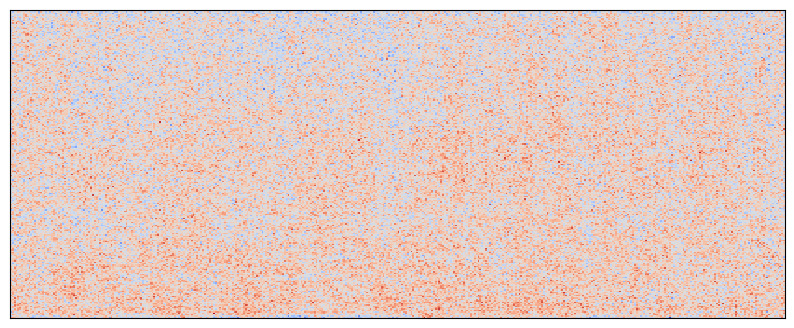

2025-03-25 09:31:46,000 - LIGHT_DEBUG - Sampling timestep 900/1000 X min/max: -5.12619, 5.60111 noise min/max: -7.31813, 8.10666 std/mean: 1.51208, 0.82791 

2025-03-25 09:31:46,603 - LIGHT_DEBUG - Normalized to range: [-1,1]


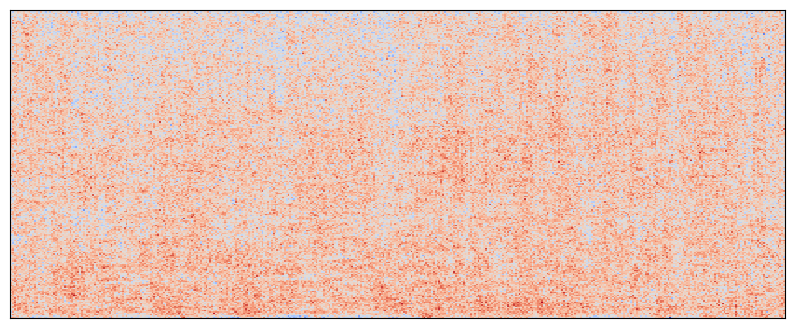

2025-03-25 09:32:06,000 - LIGHT_DEBUG - Sampling timestep 999/1000 X min/max: -5.53013, 5.52660 noise min/max: -9.64890, 6.13122 std/mean: 0.88978, 0.99597  


2025-03-25 09:32:06,408 - LIGHT_DEBUG - Final X min/max before return: -5.53013, 5.52660
2025-03-25 09:32:06,412 - INFO - Created 8 samples


In [6]:
#bwd_pass(diffusion, n_samples=8, file_name="test")
#x: ndarray = diffusion.bwd_diffusion_ddim(n_samples=8, sampling_timesteps=100, eta = 0)
x: ndarray = diffusion.bwd_diffusion_ddpm(n_samples=8, visual_freq=100)

In [ ]:
print(np.std(file), np.mean(file))

-5.530133 5.0264144


2025-03-25 09:32:10,820 - LIGHT_DEBUG - Normalized to range: [-1,1]


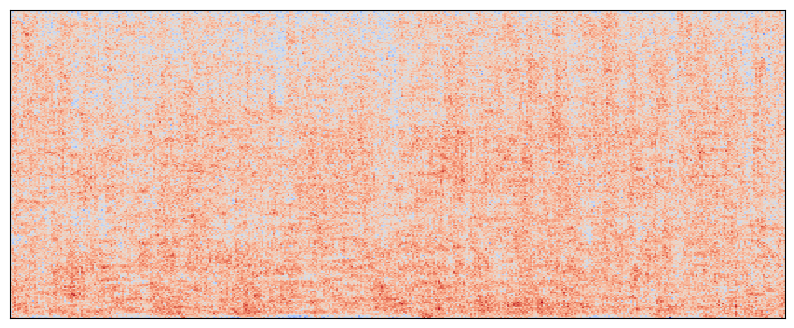

-4.6301455 4.911492


2025-03-25 09:32:11,051 - LIGHT_DEBUG - Normalized to range: [-1,1]


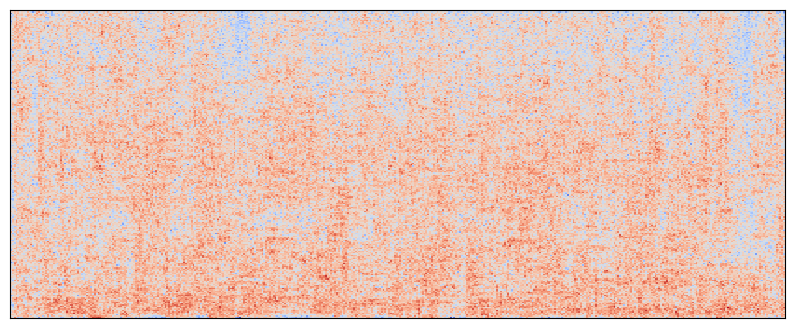

-4.100466 4.944979


2025-03-25 09:32:11,245 - LIGHT_DEBUG - Normalized to range: [-1,1]


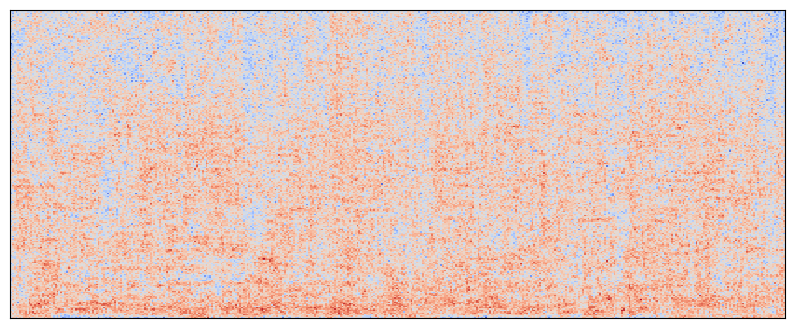

-4.4473004 5.5266047


2025-03-25 09:32:11,468 - LIGHT_DEBUG - Normalized to range: [-1,1]


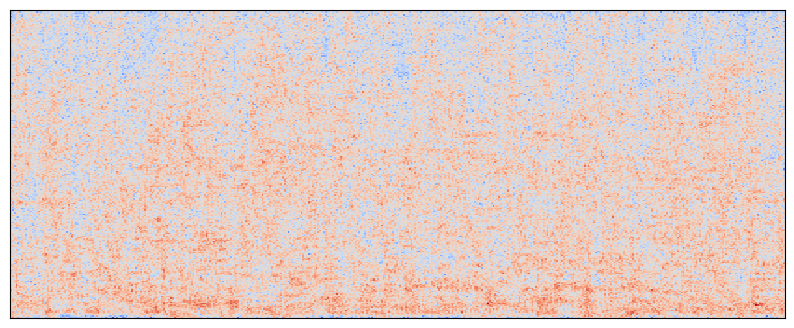

-4.0166626 5.3476057


2025-03-25 09:32:11,668 - LIGHT_DEBUG - Normalized to range: [-1,1]


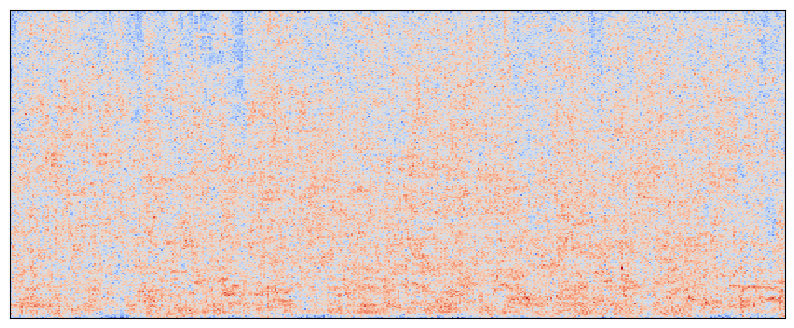

-4.346194 5.0937614


2025-03-25 09:32:11,889 - LIGHT_DEBUG - Normalized to range: [-1,1]


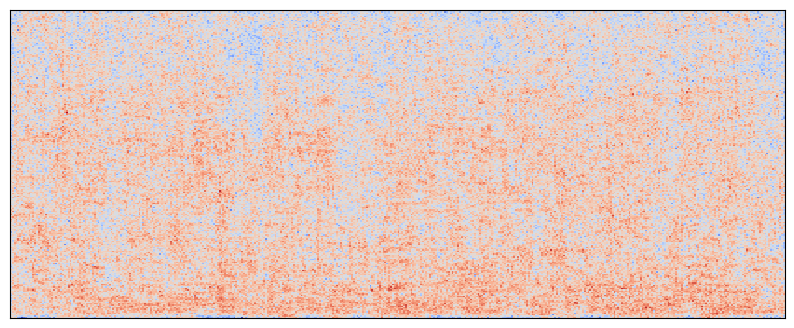

-3.84695 5.0331864


2025-03-25 09:32:12,100 - LIGHT_DEBUG - Normalized to range: [-1,1]


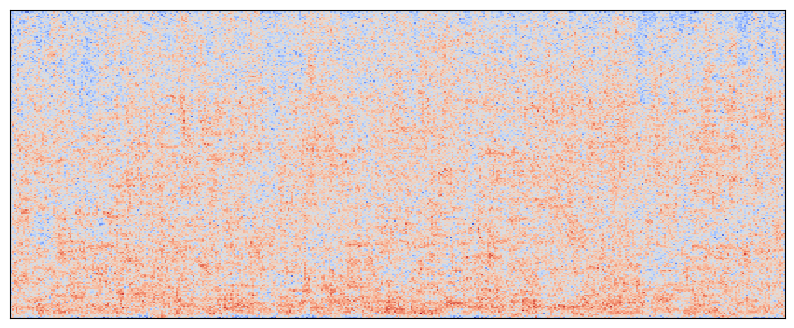

-4.0087776 5.0268164


2025-03-25 09:32:12,292 - LIGHT_DEBUG - Normalized to range: [-1,1]


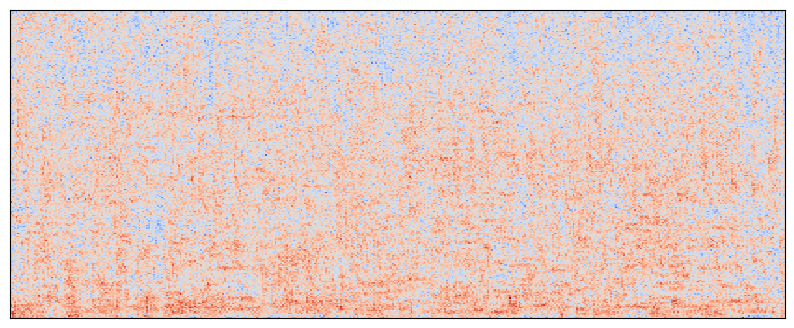

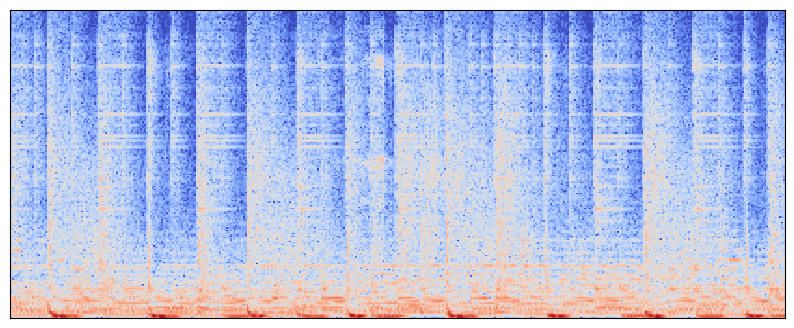

In [7]:
#print_eval_metrics(x)
for i in range(x.shape[0]):
    print(np.min(x[i,0]), np.max(x[i,0]), flush=True)
    visualize_spectogram(normalize(x[i,0], -1, 1))
#save_audio_file(spectrogram_to_audio(unnormalize(x[0,0]), conf["audio"].len_fft, conf["audio"].len_hop), path_to_remote_path("{}/{}".format(conf["paths"].result_path, "test.wav"), remote_kernel), conf["audio"].sample_rate)
visualize_spectogram(file[99])


### Save Model Architecture

In [ ]:
u_net.eval()
with torch.no_grad():
    u_net.eval()
with torch.no_grad():
    example_x = torch.randn(8, 1, file.shape[-2], file.shape[-1]).to(device)
    example_t = torch.randint(0, 500, (8,), dtype=torch.long).to(device)

    script_model = torch.jit.trace(u_net,(example_x, example_t), check_trace=False)
torch.jit.save(script_model, path_to_remote_path("{}/{}".format(conf["paths"].result_path, model_name + ".pt"), remote_kernel))
#torchviz.make_dot(model(torch.randn(BATCH_SIZE, 1, file.shape[-2], file.shape[-1])), params=dict(model.named_parameters())).render(f"{RESULT_PATH}/{model_name}", format="png") #Not working
#logger.info(f"Saved model {path_to_remote_path(f"{RESULT_PATH}/{model_name}.pt", remote_kernel)}")